### Download datasets for this model here:

* https://drive.google.com/drive/folders/19TuTEOKfSOWr4IVf9PrTnN2TQiogoyYV?usp=sharing 

In [1]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F

from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
import torchvision.transforms as transforms
%matplotlib inline

from sklearn.metrics import classification_report

import warnings
warnings.filterwarnings("ignore")

 ### Here we deifne how to tansform the the data to fit our models
 
 * With the torchvision transformer function
 * We will randomly flip images horisontally for Data augmentaion with we hope to imporve our accuracy
 * We then transform the dataset into a Tensor.
 * Therafter normalize the data.

In [2]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

#### We also have a transform function for our validation set

In [3]:
valid_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])

### We define the training and test sets.

* Here we tell torchvision where the data is, then we load in the data with the DataLoader function
* we also split the data into a training set and a test set by using the train perameters, True or false

In [4]:
dataset = torchvision.datasets.CIFAR10(root='datasets/', download=True, transform=ToTensor())

train_set = torchvision.datasets.CIFAR10('./datasets', train=True,
                                         download=True, transform=transform)
test_set = torchvision.datasets.CIFAR10('./datasets', train=False,
                                        download=True, transform=transform)

validation_set = torchvision.datasets.CIFAR10('./datasets', train=False,
                                        download=True, transform=valid_transform)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=64,
                                           shuffle=True, num_workers=4)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=64,
                                          shuffle=False, num_workers=4)

validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=64,
                                          shuffle=False, num_workers=4)




Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


### Here we import the Pyplot to assess if the images are loaded correctly or not.

* Importing matplotlip and numpy.
* We define a function to show images from the train_loader dataset
* We create a grid with torchvision and imbed the images into the grid.

In [5]:
len(validation_set), len(test_set), len(train_set)

(10000, 10000, 50000)

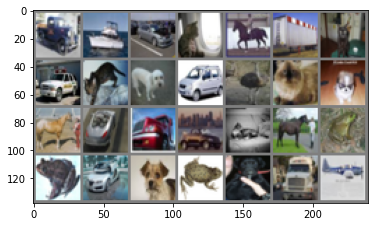

In [6]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5
    plt.imshow(np.transpose(img.numpy(), (1, 2, 0)))
    plt.show()
    
image_iter = iter(train_loader)
images, _ = image_iter.next()
imshow(torchvision.utils.make_grid(images[:28], nrow=7))

### Check how many images the training and testing datasets contain

In [7]:
dataset_size = len(train_set)
test_dataset_size = len(test_set)

print("Training dataset size", dataset_size)
print("Testing datasets size", test_dataset_size)

print(dataset)


Training dataset size 50000
Testing datasets size 10000
Dataset CIFAR10
    Number of datapoints: 50000
    Root location: datasets/
    Split: Train
    StandardTransform
Transform: ToTensor()


### Get the classes of the entire dataset

In [8]:
classes = dataset.classes
classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

### Get the Shapes of the images

In [9]:
img, label = dataset[0]
img_shape = img.shape
img_shape

torch.Size([3, 32, 32])

### Print a sample image

Label (numeric): 6
Label (textual): frog


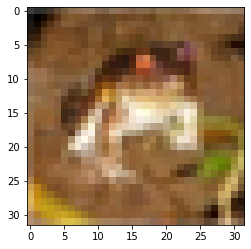

In [10]:
img, label = dataset[0]
plt.imshow(img.permute((1, 2, 0)))
print('Label (numeric):', label)
print('Label (textual):', classes[label])

### Here we determine the number of images belonging to each class?

* We define the length of the dataset
* We then check hoe many classes there are
* We create a dictionary to store the values
* we then do 2 for loops, first to get the classes and the second to count the amount of images retaining to the classes 

In [11]:
dataset_size = len(dataset)
classes = dataset.classes
num_classes = len(dataset.classes)

img_dict = {}
for i in range(num_classes):
    img_dict[classes[i]] = 0
    
for i in range(dataset_size):
    img, label = dataset[i]
    img_dict[classes[label]] += 1

img_dict

{'airplane': 5000,
 'automobile': 5000,
 'bird': 5000,
 'cat': 5000,
 'deer': 5000,
 'dog': 5000,
 'frog': 5000,
 'horse': 5000,
 'ship': 5000,
 'truck': 5000}

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


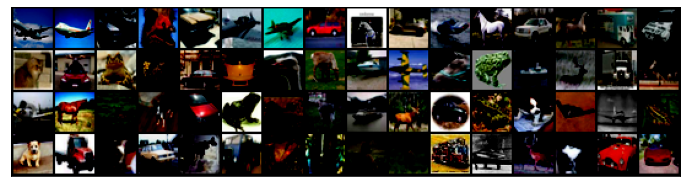

In [12]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break

show_batch(train_loader)

### Here we are creating the functionality for calculating the models accuracy

* Todo = Find out how this function works

In [13]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

### ImageClassificationBase contains 4 functions
* One function is for training and validation sets, which implement the loss and accuracy.
* The validation_epoch_end combines the losses and accuracy for each epock 
* The epoch_end prints the val_lass and val_acc at the end of each epoch

In [14]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['train_loss'], result['val_loss'], result['val_acc']))

##### nn.Sequential chains the layres and activation functions into a single network architecture

In [15]:
class Cifar10CnnModel(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 16 x 16

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 8 x 8

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 256 x 4 x 4

            nn.Flatten(), 
            nn.Linear(256*4*4, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 10))
        
    def forward(self, xb):
        return self.network(xb)

In [16]:
print(Cifar10CnnModel)

<class '__main__.Cifar10CnnModel'>


### Here we move our model to GPU if it can run it

In [17]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        print("Model will run on, GPU")
        return torch.device('cuda')
    else:
        print("Model will run on, CPU")
        return torch.device('cpu')


In [18]:
device = get_default_device()
device

Model will run on, GPU


device(type='cuda')

#### Here we load the data into the GPU device

In [19]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [20]:
train_loader = DeviceDataLoader(train_loader, device)
validation_loader = DeviceDataLoader(validation_loader, device)
test_loader = DeviceDataLoader(test_loader, device)

In [21]:
model = Cifar10CnnModel()
model

Cifar10CnnModel(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=4096, out_features=1024, bias=True)
    (17): ReLU()
    (18): Linear(in_feat

In [22]:
model = to_device(model, device)

### The fit function records the validation loss and metric from each epoch. It returns a history of the training, useful for debugging & visualization.

In [23]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

# def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.Adam):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [24]:
history = [evaluate(model, validation_loader)]
history

[{'val_acc': 0.10041799396276474, 'val_loss': 2.3030998706817627}]

### Here we define the input and output size

In [25]:
input_size = 3*32*32
output_size = 10

### Number of epochs to cycle through and the learning rate is set here

In [26]:
num_epochs = 10
opt_func = torch.optim.Adam
lr = 0.001

### The fit function will record validation loss and metrics for each epoch

In [27]:
history += fit(num_epochs, lr, model, train_loader, validation_loader, opt_func)

Epoch [0], train_loss: 1.5474, val_loss: 1.3008, val_acc: 0.5366
Epoch [1], train_loss: 1.0123, val_loss: 0.8749, val_acc: 0.6923
Epoch [2], train_loss: 0.7715, val_loss: 0.7613, val_acc: 0.7397
Epoch [3], train_loss: 0.6400, val_loss: 0.6414, val_acc: 0.7790
Epoch [4], train_loss: 0.5458, val_loss: 0.7013, val_acc: 0.7643
Epoch [5], train_loss: 0.4838, val_loss: 0.6153, val_acc: 0.7935
Epoch [6], train_loss: 0.4197, val_loss: 0.5901, val_acc: 0.8043
Epoch [7], train_loss: 0.3790, val_loss: 0.5770, val_acc: 0.8154
Epoch [8], train_loss: 0.3335, val_loss: 0.6720, val_acc: 0.7970
Epoch [9], train_loss: 0.3075, val_loss: 0.5962, val_acc: 0.8136


### These functions will plot the losses and accuracy of the history i.e. the training

In [28]:
def plot_losses(history):
    losses = [x['val_loss'] for x in history]
    plt.plot(losses, '-x')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title('Loss vs. No. of epochs');
    
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs'); 

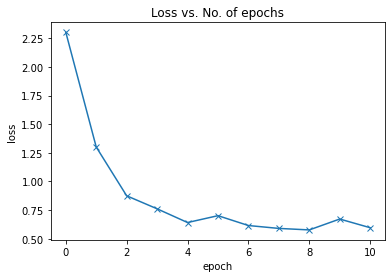

In [29]:
plot_losses(history)

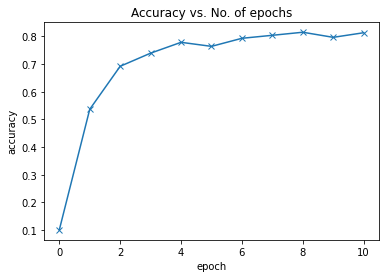

In [30]:
plot_accuracies(history)

### this function will plot will plott the loss difference between the validation set and the training setmm

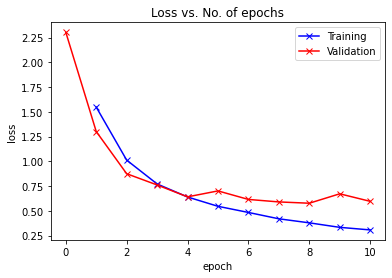

In [31]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs')
    
plot_losses(history);

### Get the accuraccy results for each class

In [32]:
type(images)

torch.Tensor

In [ ]:
type(labels)

In [33]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}
y_actual = []
y_pred = []
confusion_matrix = np.zeros([10,10], int)

# again no gradients needed
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = model(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1
            y_actual.append(label.item())
            y_pred.append(prediction.item())
        for i, l in enumerate(labels):
            confusion_matrix[l.item(), predictions[i].item()] += 1 

for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print("Accuracy for class {:5s} is: {:.1f} %".format(classname,
                                                   accuracy))

Accuracy for class airplane is: 83.1 %
Accuracy for class automobile is: 88.7 %
Accuracy for class bird  is: 76.9 %
Accuracy for class cat   is: 68.6 %
Accuracy for class deer  is: 74.6 %
Accuracy for class dog   is: 74.7 %
Accuracy for class frog  is: 86.1 %
Accuracy for class horse is: 85.1 %
Accuracy for class ship  is: 89.8 %
Accuracy for class truck is: 90.4 %


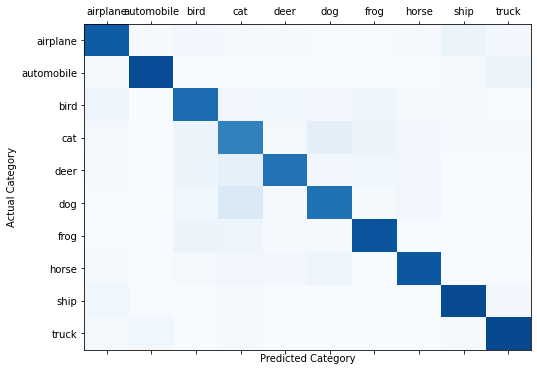

In [34]:
fig, ax = plt.subplots(1,1,figsize=(8,6))
ax.matshow(confusion_matrix, aspect='auto', vmin=0, vmax=1000, cmap=plt.get_cmap('Blues'))
plt.ylabel('Actual Category')
plt.yticks(range(10), classes)
plt.xlabel('Predicted Category')
plt.xticks(range(10), classes)
plt.show()

In [35]:
print('actual/pred'.ljust(16), end='')
for i,c in enumerate(classes):
    print(c.ljust(10), end='')
print()
for i,r in enumerate(confusion_matrix):
    print(classes[i].ljust(16), end='')
    for idx, p in enumerate(r):
        print(str(p).ljust(10), end='')
    print()
    r = r/np.sum(r)
    print(''.ljust(16), end='')
    for idx, p in enumerate(r):
        print(str(p).ljust(10), end='')
    print()

actual/pred     airplane  automobilebird      cat       deer      dog       frog      horse     ship      truck     
airplane        831       9         27        18        8         6         7         10        60        24        
                0.831     0.009     0.027     0.018     0.008     0.006     0.007     0.01      0.06      0.024     
automobile      9         887       2         5         2         2         5         1         21        66        
                0.009     0.887     0.002     0.005     0.002     0.002     0.005     0.001     0.021     0.066     
bird            48        2         769       34        37        34        44        20        8         4         
                0.048     0.002     0.769     0.034     0.037     0.034     0.044     0.02      0.008     0.004     
cat             20        1         61        686       21        99        59        35        8         10        
                0.02      0.001     0.061     0.686     0.021   

In [36]:
TP = 0
FP = 0
FN = 0

for i,r in enumerate(confusion_matrix):
    total = 0
    thisTP = 0
    thisFN = 0
    thisFP = 0 
    for i3 in range (0,10):
        if (i != i3):
            thisFP += confusion_matrix[i3][i]
    for i2,r2 in enumerate(r):
        total += r2
        if (i == i2):
            thisTP += r2
        else:
            thisFN += r2
    
    print(classes[i])
    print('True positives %d' % (thisTP))
    print('False positives %d' % (thisFP))
    print('False negatives %d' % (thisFN))
    precision = thisTP / (thisTP + thisFP)
    recall = thisTP / (thisTP + thisFN)
    print('Precicion {}'.format(precision))
    print('Recall {}'.format(recall))
    f1 = (2 * (precision*recall)) / (precision + recall)
    print('F1 {}'.format(f1))

airplane
True positives 831
False positives 167
False negatives 169
Precicion 0.8326653306613226
Recall 0.831
F1 0.8318318318318317
automobile
True positives 887
False positives 61
False negatives 113
Precicion 0.9356540084388185
Recall 0.887
F1 0.9106776180698152
bird
True positives 769
False positives 266
False negatives 231
Precicion 0.7429951690821256
Recall 0.769
F1 0.7557739557739558
cat
True positives 686
False positives 383
False negatives 314
Precicion 0.6417212347988774
Recall 0.686
F1 0.6631222812953117
deer
True positives 746
False positives 131
False negatives 254
Precicion 0.8506271379703535
Recall 0.746
F1 0.7948854555141183
dog
True positives 747
False positives 233
False negatives 253
Precicion 0.7622448979591837
Recall 0.747
F1 0.7545454545454545
frog
True positives 861
False positives 175
False negatives 139
Precicion 0.831081081081081
Recall 0.861
F1 0.8457760314341848
horse
True positives 851
False positives 144
False negatives 149
Precicion 0.8552763819095477
Reca

In [37]:
from sklearn.metrics import matthews_corrcoef
matthews_corrcoef(y_actual, y_pred)

0.7979012758560037

In [38]:
from sklearn.metrics import classification_report
print(classification_report(y_actual, y_pred, target_names=classes))

              precision    recall  f1-score   support

    airplane       0.83      0.83      0.83      1000
  automobile       0.94      0.89      0.91      1000
        bird       0.74      0.77      0.76      1000
         cat       0.64      0.69      0.66      1000
        deer       0.85      0.75      0.79      1000
         dog       0.76      0.75      0.75      1000
        frog       0.83      0.86      0.85      1000
       horse       0.86      0.85      0.85      1000
        ship       0.88      0.90      0.89      1000
       truck       0.87      0.90      0.88      1000

    accuracy                           0.82     10000
   macro avg       0.82      0.82      0.82     10000
weighted avg       0.82      0.82      0.82     10000



In [39]:
from sklearn.metrics import cohen_kappa_score
print(cohen_kappa_score(y_actual, y_pred))

0.7977777777777778


In [40]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [41]:
#Getting the numpy data into lists.
import os
import pathlib
import numpy as np
import pandas as pd
from matplotlib import pyplot
def load_new_test_data(version_string='', load_tinyimage_indices=False):
    data_path = '/content/drive/MyDrive/AAI_Exam/datasets/cifar-10_unseen/'
    filename = 'cifar10.1'
    if version_string == '':
        version_string = 'v7'
    if version_string in ['v4', 'v6', 'v7']:
        filename += '_' + version_string
    else:
        raise ValueError('Unknown dataset version "{}".'.format(version_string))
    label_filename = filename + '_labels.npy'
    imagedata_filename = filename + '_data.npy'
    label_filepath = os.path.abspath(os.path.join(data_path, label_filename))
    imagedata_filepath = os.path.abspath(os.path.join(data_path, imagedata_filename))
    print('Loading labels from file {}'.format(label_filepath))
    assert pathlib.Path(label_filepath).is_file()
    labels = np.load(label_filepath)
    print('Loading image data from file {}'.format(imagedata_filepath))
    assert pathlib.Path(imagedata_filepath).is_file()
    imagedata = np.load(imagedata_filepath)
    assert len(labels.shape) == 1
    assert len(imagedata.shape) == 4
    assert labels.shape[0] == imagedata.shape[0]
    assert imagedata.shape[1] == 32
    assert imagedata.shape[2] == 32
    assert imagedata.shape[3] == 3
    if version_string == 'v6' or version_string == 'v7':
        assert labels.shape[0] == 2000
    elif version_string == 'v4':
        assert labels.shape[0] == 2021

    if not load_tinyimage_indices:
        return imagedata, labels
    else:
        ti_indices_data_path = os.path.join(os.path.dirname(__file__), './data/')
        ti_indices_filename = 'cifar10.1_' + version_string + '_ti_indices.json'
        ti_indices_filepath = os.path.abspath(os.path.join(ti_indices_data_path, ti_indices_filename))
        print('Loading Tiny Image indices from file {}'.format(ti_indices_filepath))
        assert pathlib.Path(ti_indices_filepath).is_file()
        with open(ti_indices_filepath, 'r') as f:
            tinyimage_indices = json.load(f)
        assert type(tinyimage_indices) is list
        assert len(tinyimage_indices) == labels.shape[0]
        return imagedata, labels, tinyimage_indices

In [42]:
images, labels = load_new_test_data('v4')

Loading labels from file /content/drive/MyDrive/AAI_Exam/datasets/cifar-10_unseen/cifar10.1_v4_labels.npy
Loading image data from file /content/drive/MyDrive/AAI_Exam/datasets/cifar-10_unseen/cifar10.1_v4_data.npy


In [43]:
#Finding the number of occurences for each class in the new dataset
cifar10_label_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
classes = {  "airplane": 0,
          "automobile": 0,
          "bird": 0,
          "cat": 0,
          "deer": 0,
          "dog": 0,
          "frog": 0,
          "horse": 0,
          "ship": 0,
          "truck": 0
       }
for i in range(len(images)):
    for i2 in range(len(cifar10_label_names)):
        if i2 == labels[i]:
            # images[i].label = labels[i]
            classes[cifar10_label_names[i2]] = classes[cifar10_label_names[i2]] + 1
        
print(classes)

{'airplane': 208, 'automobile': 212, 'bird': 202, 'cat': 212, 'deer': 204, 'dog': 218, 'frog': 192, 'horse': 210, 'ship': 161, 'truck': 202}


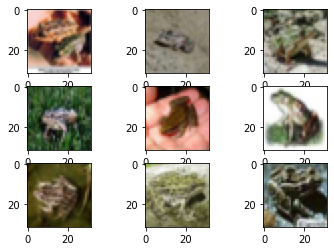

In [44]:
for i in range(9):
	# define subplot
	pyplot.subplot(330 + 1 + i)
	# plot raw pixel data
	pyplot.imshow(images[i])
# show the figure
pyplot.show()

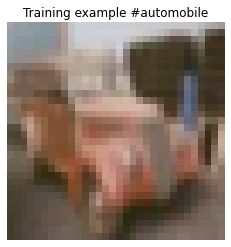

In [45]:
import random

random_image = random.randint(0, len(images))
plt.imshow(images[random_image])
plt.title(f"Training example #{cifar10_label_names[labels[random_image]]}")
plt.axis('off')
plt.show()

In [46]:
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as T
import torch
import torch.nn as nn
from torchvision.utils import make_grid
from torchvision.utils import save_image
from IPython.display import Image
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

class NormalizeAndTensorize(Dataset):
    'Characterizes a dataset for PyTorch'
    def __init__(self, X):
        'Initialization'
        self.X = X

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.X)

    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        image = self.X[index]
        X = self.transform(image)
        return X
        
    transform = T.Compose([
        T.ToPILImage(),
        T.Resize(32),
        # T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        T.ToTensor()])

In [47]:
print(type(images[0][0][0][0]))

<class 'numpy.uint8'>


In [48]:
batch_size = 64
unseen_images = NormalizeAndTensorize(images)
unseen_images_loader = DataLoader(unseen_images, batch_size, shuffle=True, num_workers=4, pin_memory=True)

In [49]:
type(unseen_images)

__main__.NormalizeAndTensorize

In [50]:
type(unseen_images_loader)

torch.utils.data.dataloader.DataLoader

In [51]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return dataset.classes[preds[0].item()]

In [52]:
type(images)

numpy.ndarray

In [53]:
type(unseen_images)

__main__.NormalizeAndTensorize

Label: automobile , Predicted: automobile


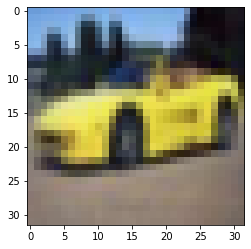

In [54]:
random_image = random.randint(0, len(unseen_images))
random_image
img = unseen_images[random_image]
plt.imshow(img.permute(1, 2, 0))
print('Label:', cifar10_label_names[labels[random_image]], ', Predicted:', predict_image(img, model))

In [55]:
wrong = 0
true_possitive = 0
for i in range(len(unseen_images)):
  img = unseen_images[i]
  if cifar10_label_names[labels[i]] == predict_image(img, model):
    true_possitive = true_possitive + 1
  else:
    wrong = wrong + 1

In [56]:
wrong

1115

In [57]:
true_possitive

906

In [ ]:
type(images)

In [60]:
images = np.arange(1, 11)
images = torch.from_numpy(images)

In [62]:
type(images)

torch.Tensor

In [63]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}
y_actual = []
y_pred = []
confusion_matrix = np.zeros([10,10], int)

# again no gradients needed
with torch.no_grad():
    for data in unseen_images_loader:
        images, labels = data
        outputs = model(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1
            y_actual.append(label.item())
            y_pred.append(prediction.item())
        for i, l in enumerate(labels):
            confusion_matrix[l.item(), predictions[i].item()] += 1 

for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print("Accuracy for class {:5s} is: {:.1f} %".format(classname,
                                                   accuracy))

ValueError: ignored

In [ ]:
result = evaluate(model, unseen_images)
result